In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
shap.initjs()
%matplotlib inline
task_name = '04'

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
feature_names = np.array(['x1', 'x2'])
n_features = len(feature_names)
n_samples = X.shape[0]

In [3]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

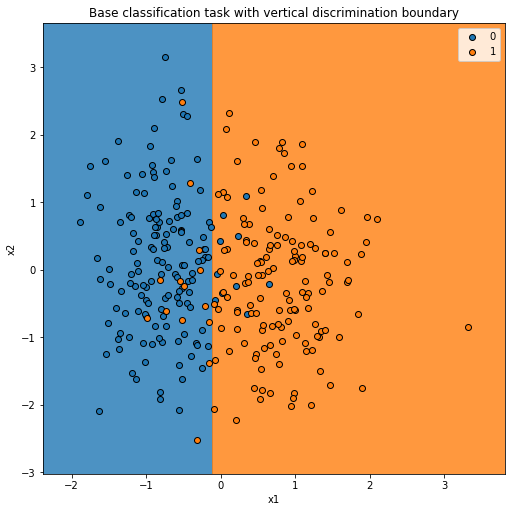

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with vertical discrimination boundary', feature_names,
                       predict=tree.predict, class_names=tree.classes_,
                       fig=fig, ax=ax)

In [5]:
clf_a = tree

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class ModifiedClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, base_model):
         self.base_model = base_model
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X2 = X.copy()
        X2[X[:, 1] >= 0, 0] -= 0.25
        return self.base_model.predict(X2)
    
clf_b = ModifiedClassifier(tree)
clf_b.fit(X, y)

ModifiedClassifier(base_model=DecisionTreeClassifier(max_depth=1))

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

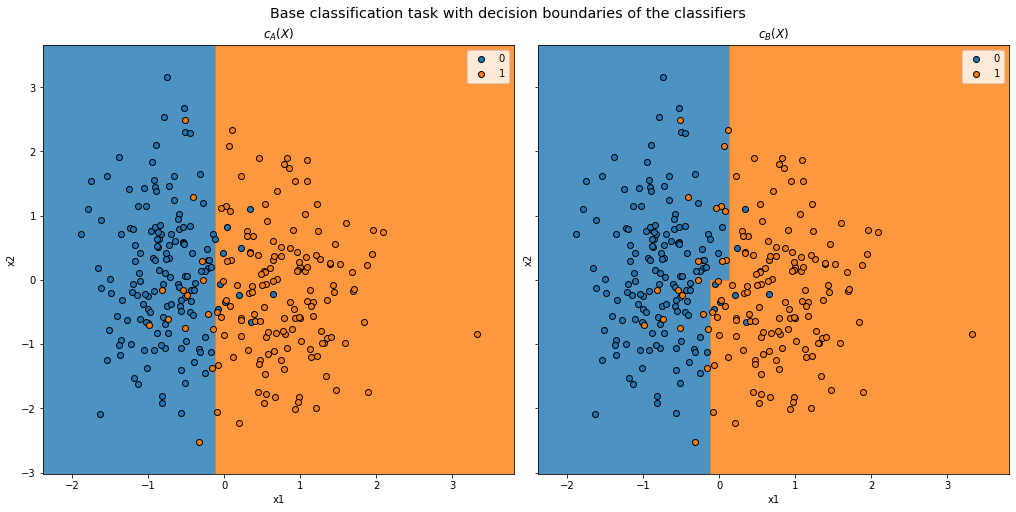

In [8]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

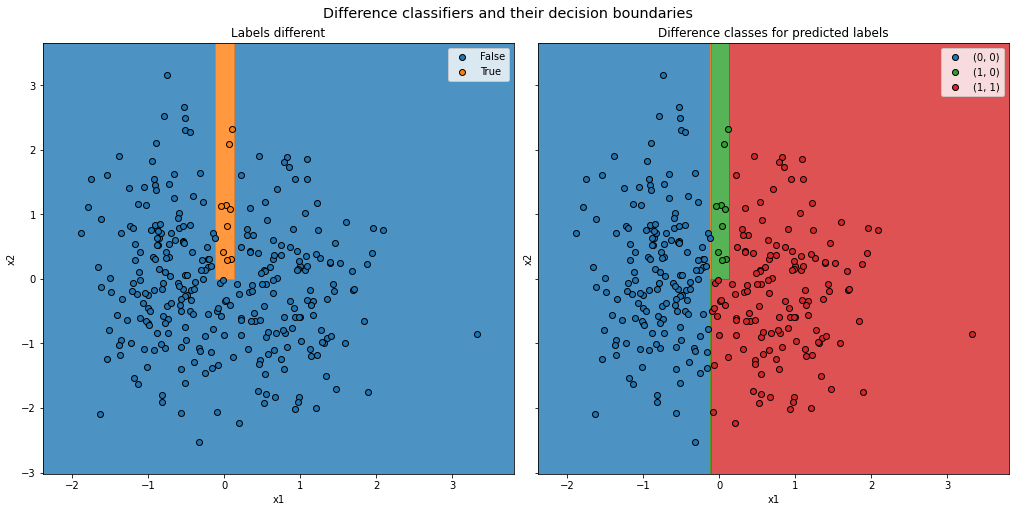

In [9]:
comparer.plot_decision_boundaries(X)

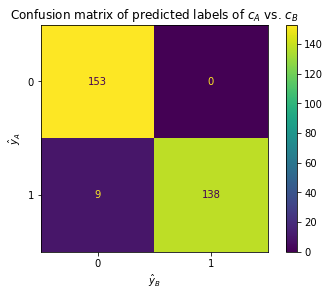

In [10]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [11]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10.6 s, sys: 199 ms, total: 10.8 s
Wall time: 11.6 s


In [12]:
with open(task_name + '.expl', 'rb') as f:
    explanations = pickle.load(f)

## Visualize SHAP values

### Individual explanations

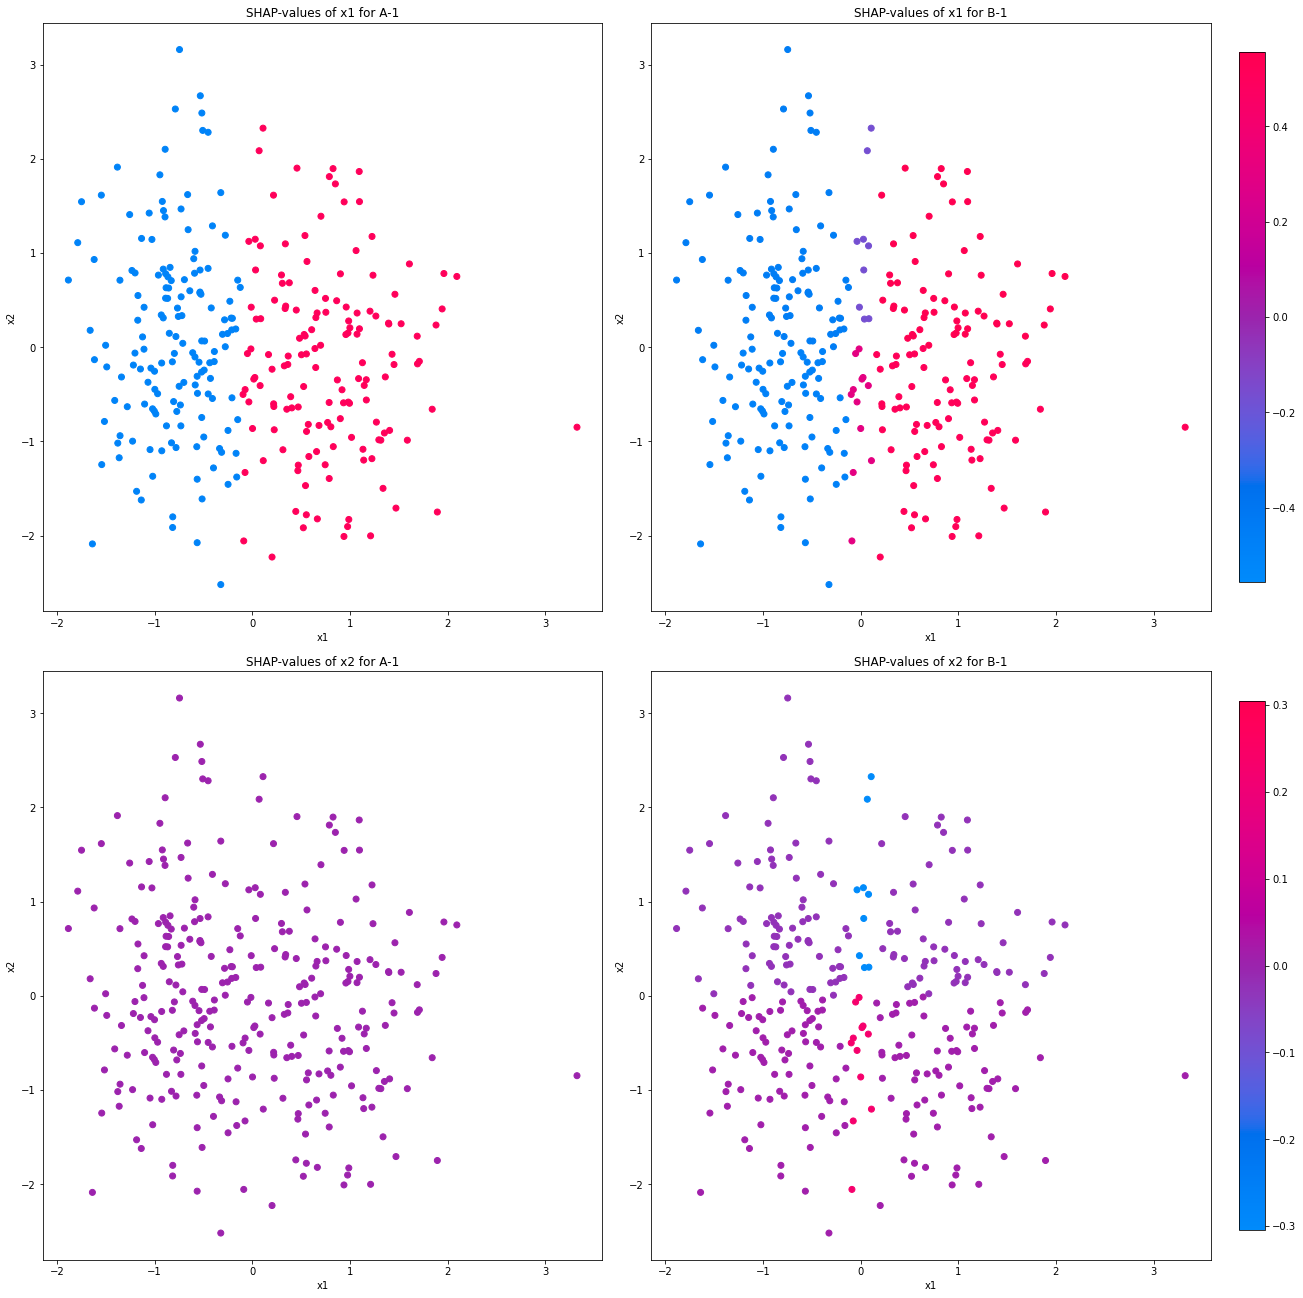

In [13]:
plot_2d(explanations.indiv.labels[:, :, ['A-1', 'B-1']])

### Simple subtraction explanation

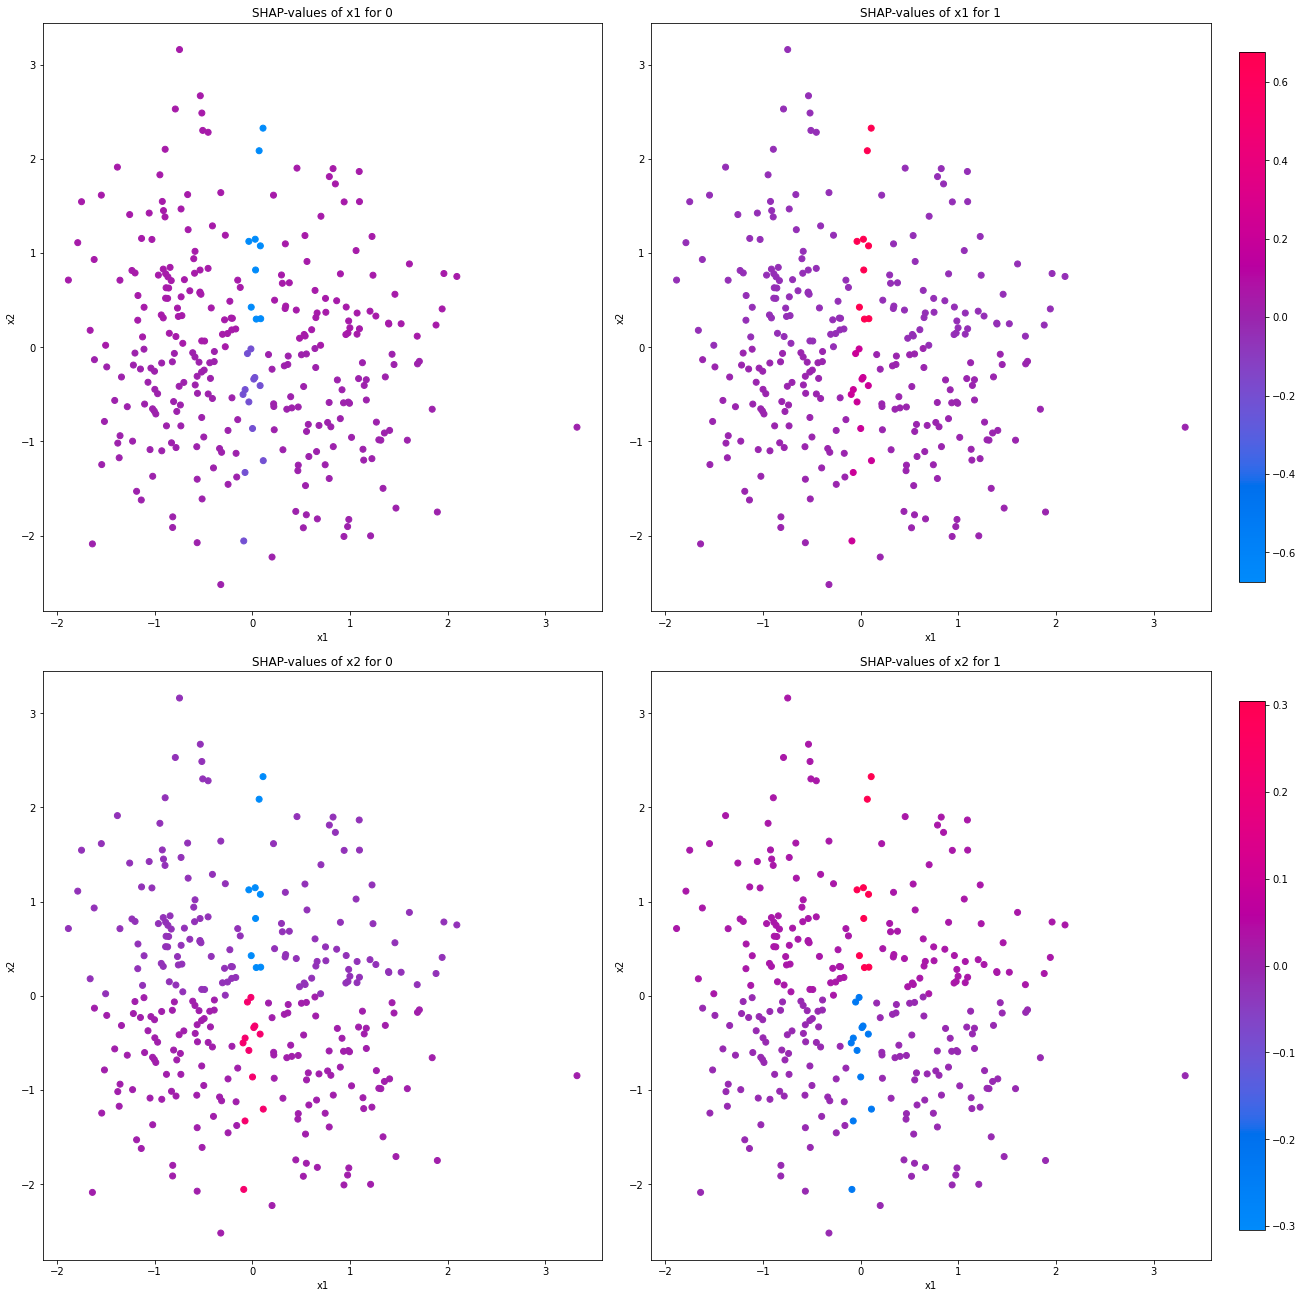

In [14]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

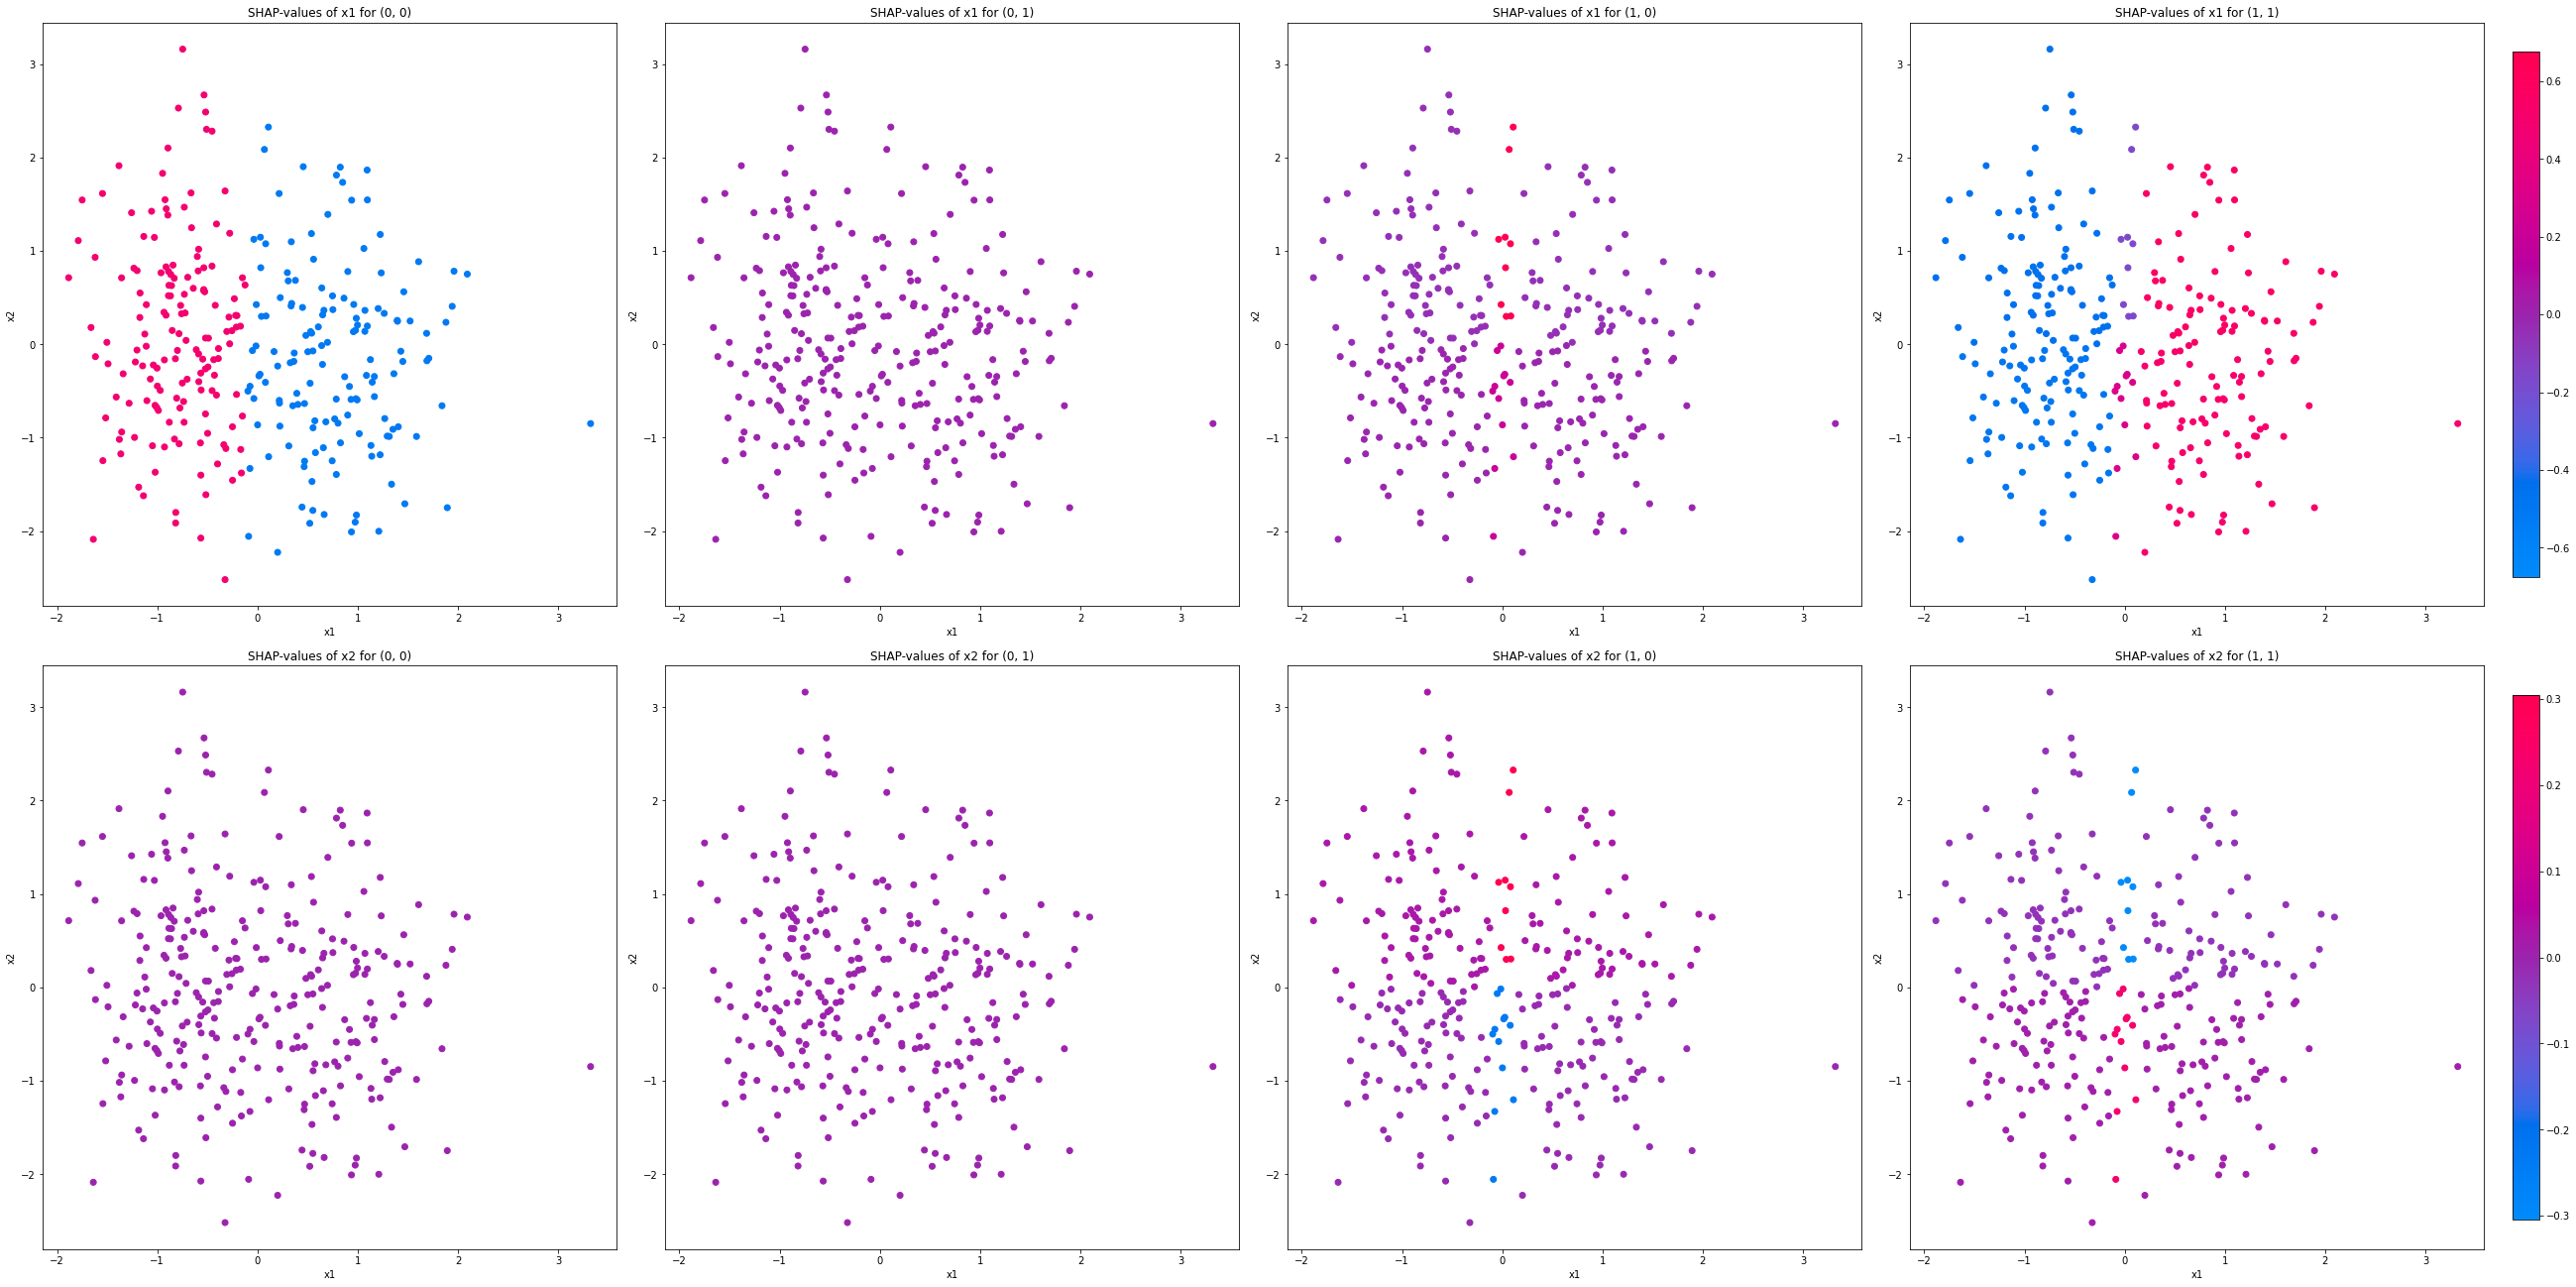

In [15]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

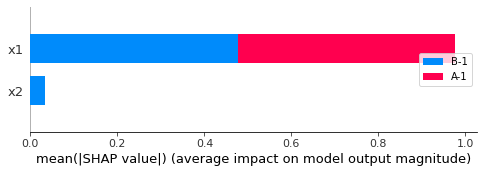

In [16]:
plot_feature_importance_bar(explanations.indiv.labels[:, :, ['A-1', 'B-1']])

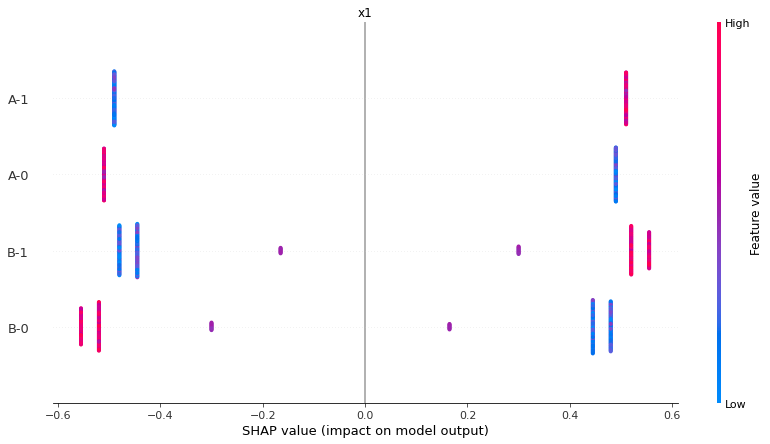

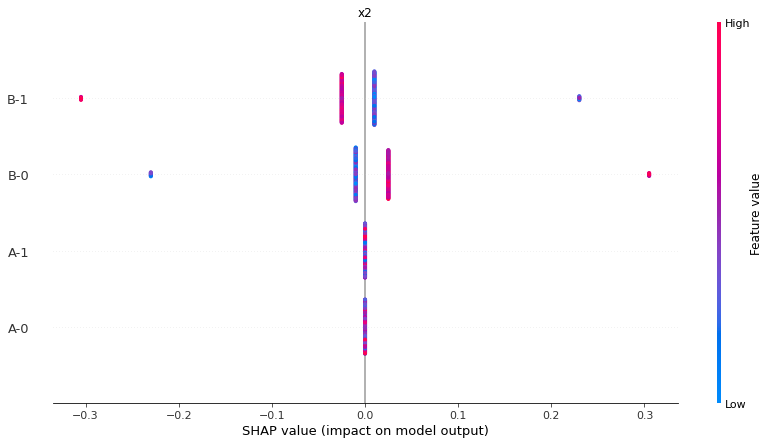

In [17]:
plot_feature_importance_scatter(explanations.indiv.labels)

### Simple subtraction explanation

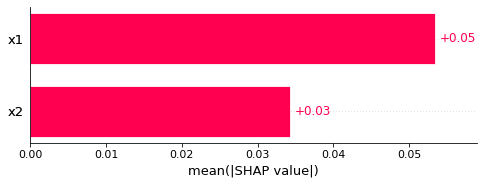

In [18]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

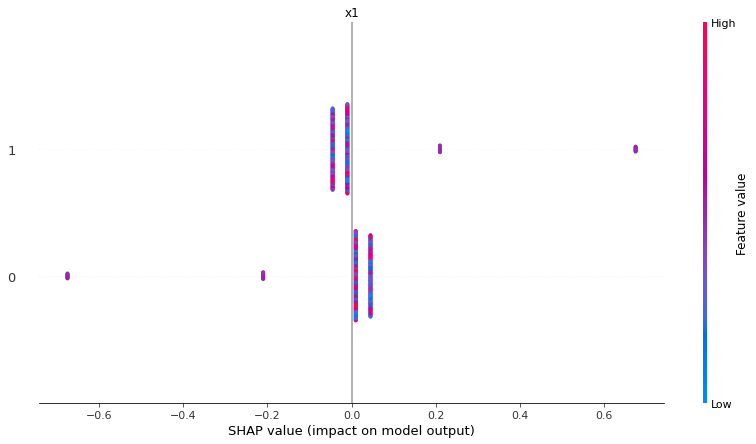

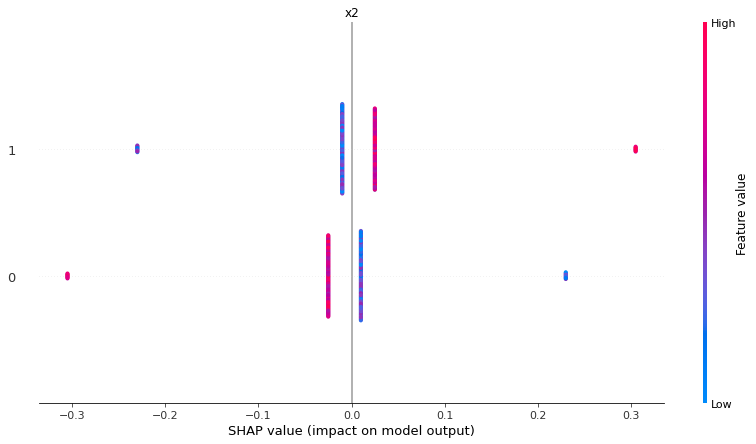

In [19]:
plot_feature_importance_scatter(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

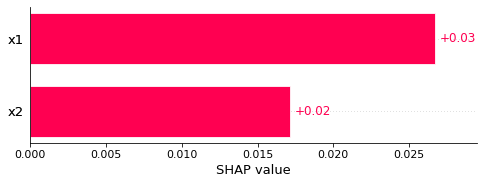

In [20]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

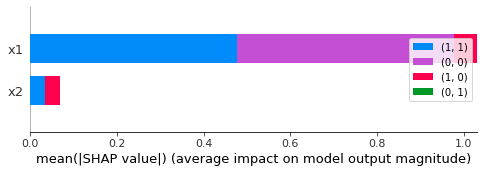

In [21]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

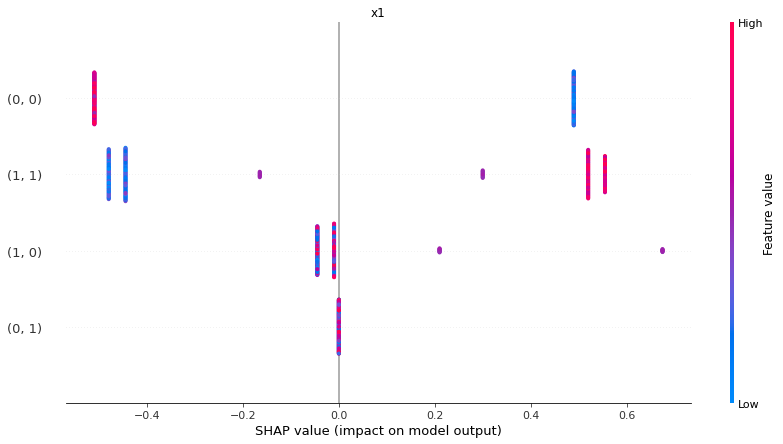

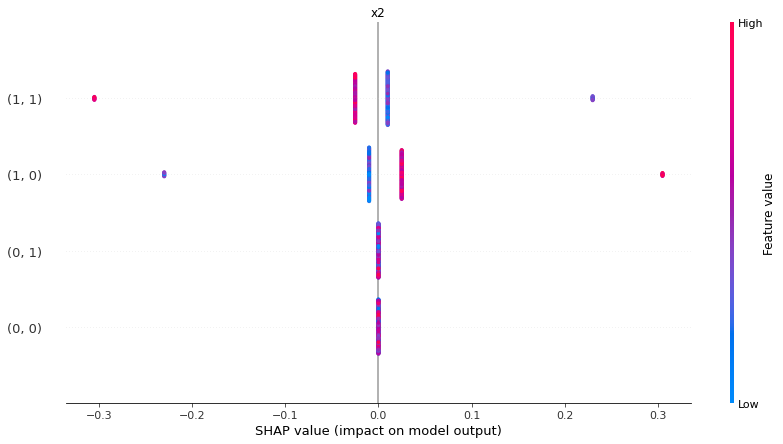

In [22]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

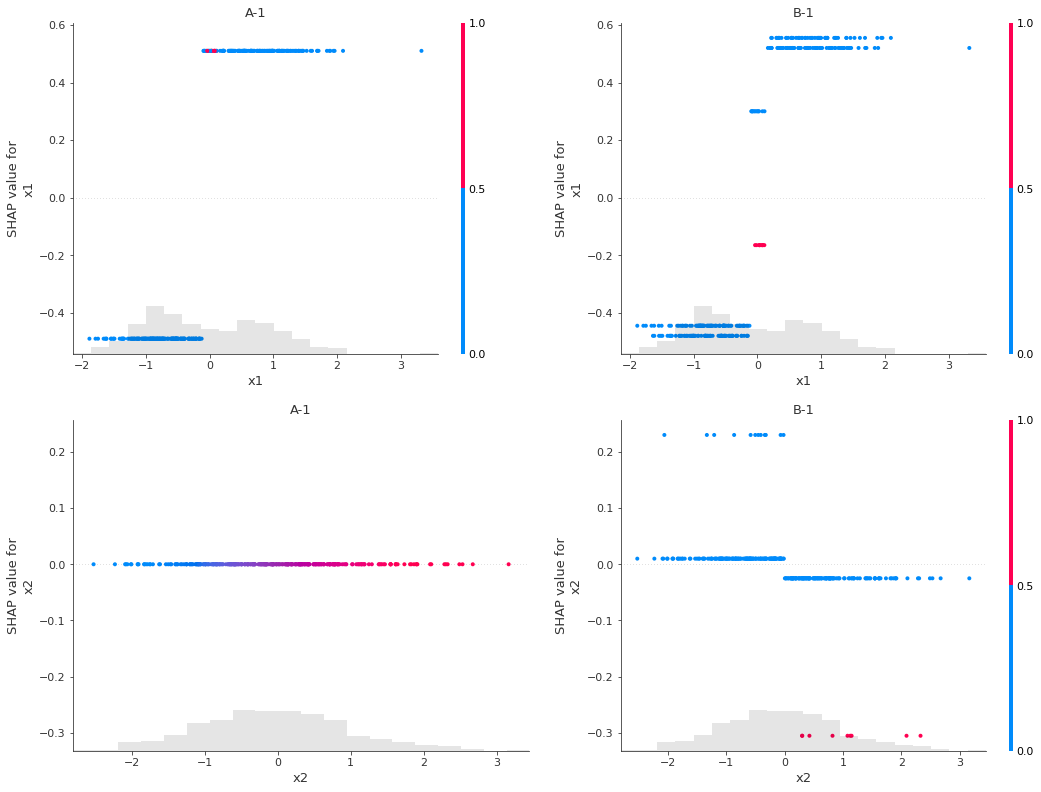

In [23]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels[:, :, ['A-1', 'B-1']], color=is_pred_diff)

### Simple subtraction explanation

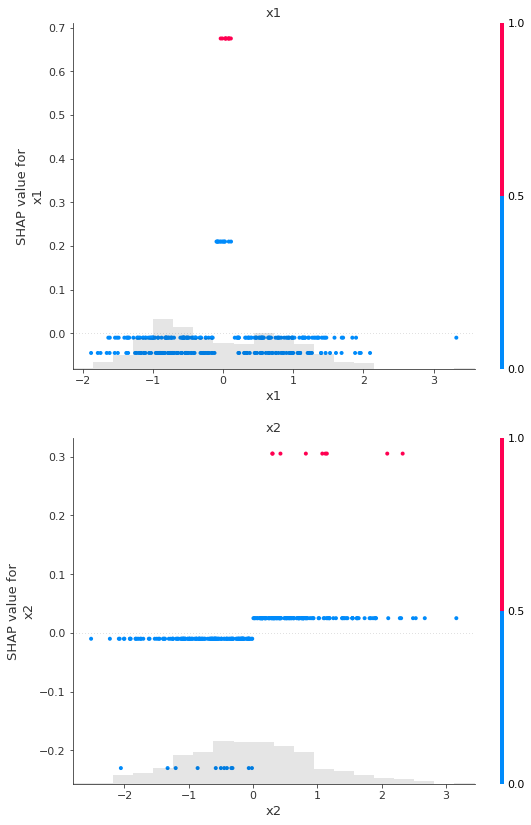

In [24]:
plot_feature_effects(explanations.indiv_diff.labels[:, :, 1], color=is_pred_diff)

### Multiclass difference classifier explanations

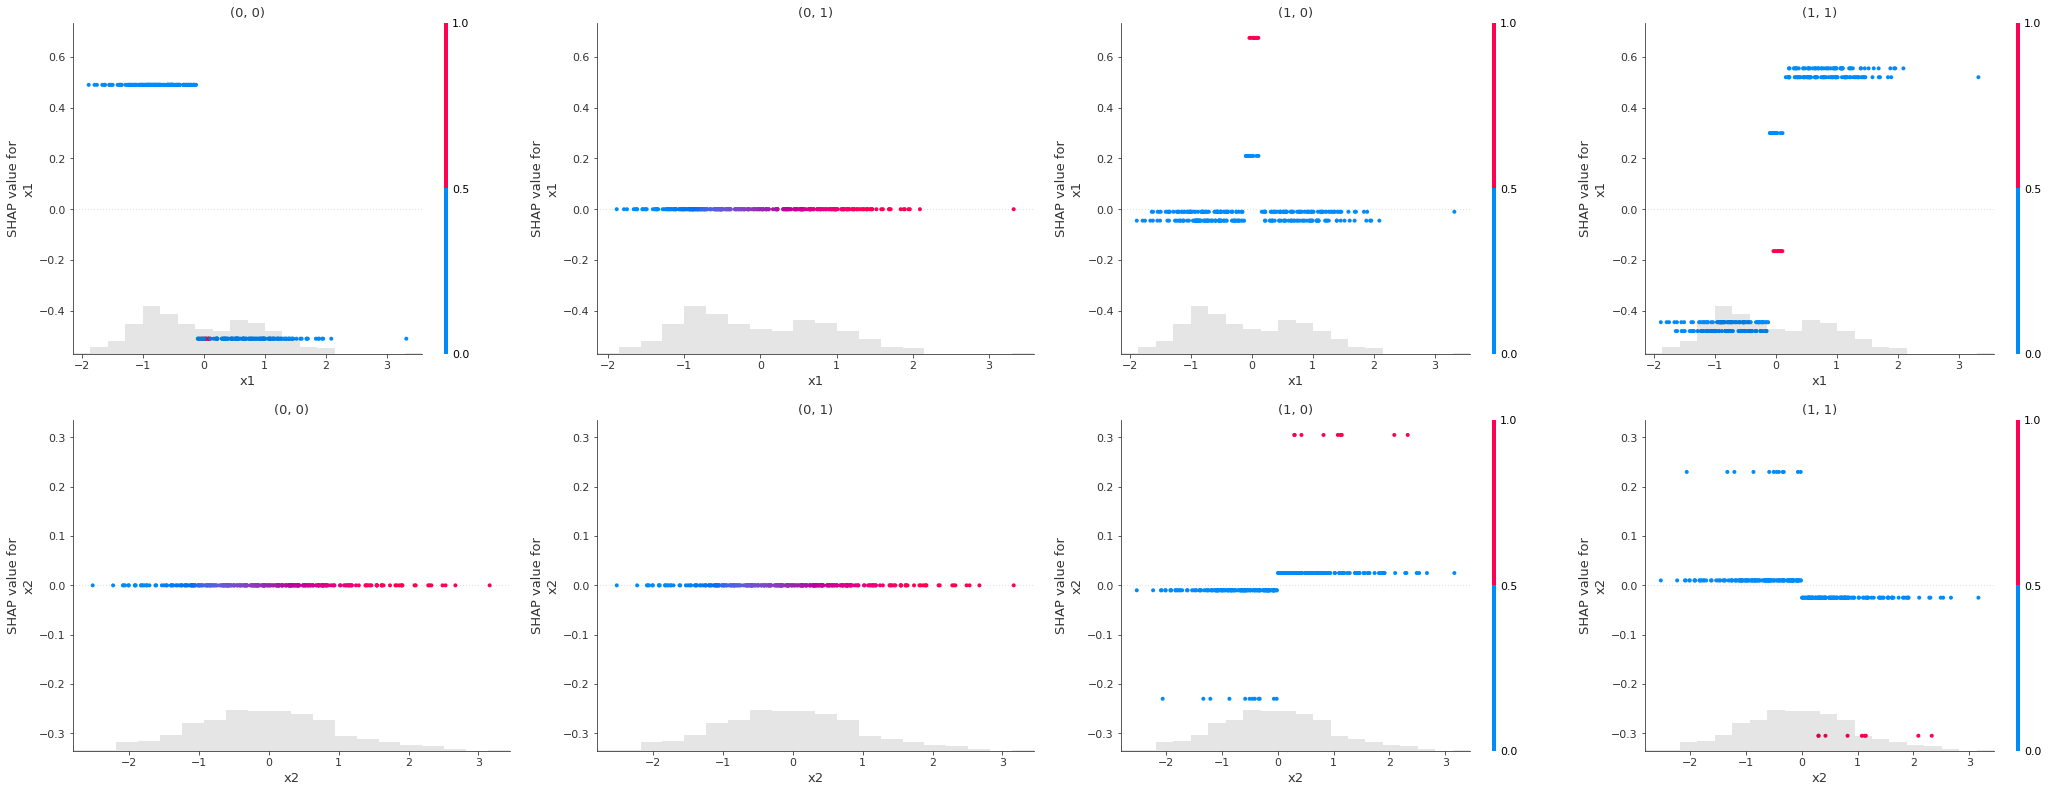

In [25]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

## Cluster instances

### Individual explanations

In [26]:
instance_order = calc_instance_order(explanations.indiv.labels)
plot_forces(explanations.indiv.labels[:, :, ['A-1', 'B-1']], instance_order=instance_order)

### Simple subtraction explanation

In [27]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [28]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)